In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# CSV dosyasını oku
VT = pd.read_csv("data/processed_VT_Data.csv")

In [3]:
# Set the pandas option to display all columns when printing the DataFrame
# This ensures that no columns are hidden, which is useful when dealing with wide DataFrames
pd.set_option('display.max_columns',None)

Target Variable

In [5]:
class_counts = VT["Training_Program"].value_counts()
VT_class = pd.DataFrame(class_counts).reset_index()
VT_class.columns = ["Training Program", "Count"]
print(VT_class)

    Training Program  Count
0                  0     27
1                  4     22
2                  3     13
3                  6     13
4                  7     12
5                  8     12
6                  1     11
7                  5      9
8                  9      8
9                 11      7
10                 2      7
11                10      7


In [6]:
class_proportion = VT["Training_Program"].value_counts(normalize=True).round(2)
VT_class_proportion = pd.DataFrame(class_proportion).reset_index()
VT_class.columns = ["Training Program", "Proportion"]
print(VT_class_proportion)

    Training_Program  proportion
0                  0        0.18
1                  4        0.15
2                  3        0.09
3                  6        0.09
4                  7        0.08
5                  8        0.08
6                  1        0.07
7                  5        0.06
8                  9        0.05
9                 11        0.05
10                 2        0.05
11                10        0.05


Distribution Analysis

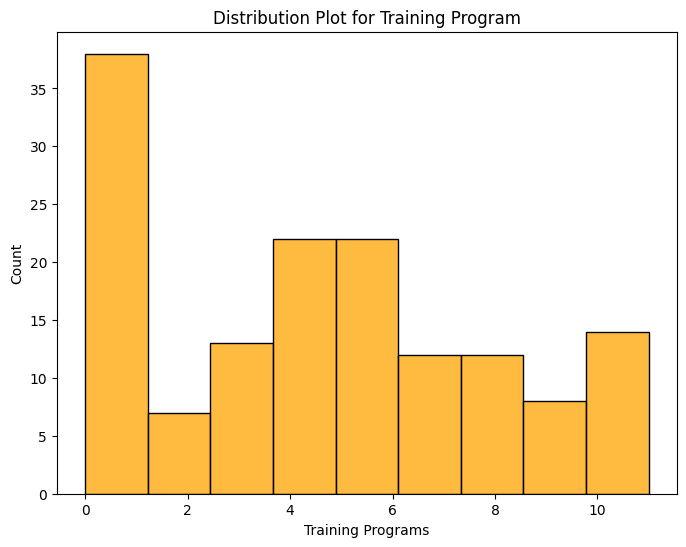

In [8]:
# Training_Program dağılımı için histogram ve KDE
plt.figure(figsize=(8, 6))  
sns.histplot(data=VT, x='Training_Program', kde=False, color='orange')  # KDE çizgisi gerekli değil cunku kategorik degisken
plt.title('Distribution Plot for Training Program')
plt.xlabel('Training Programs')
plt.ylabel('Count')

plt.show()

In [9]:
columns_to_plot = VT.drop(columns=["Training_Program","chronic_conditions","surgeries"]).columns
print(columns_to_plot)

Index(['gender', 'height', 'weight', 'age', 'resting_pulse',
       'sports_experience', 'body_fat', 'goals', 'BMI', 'W/Hip_Ratio',
       'W/Height_Ratio'],
      dtype='object')


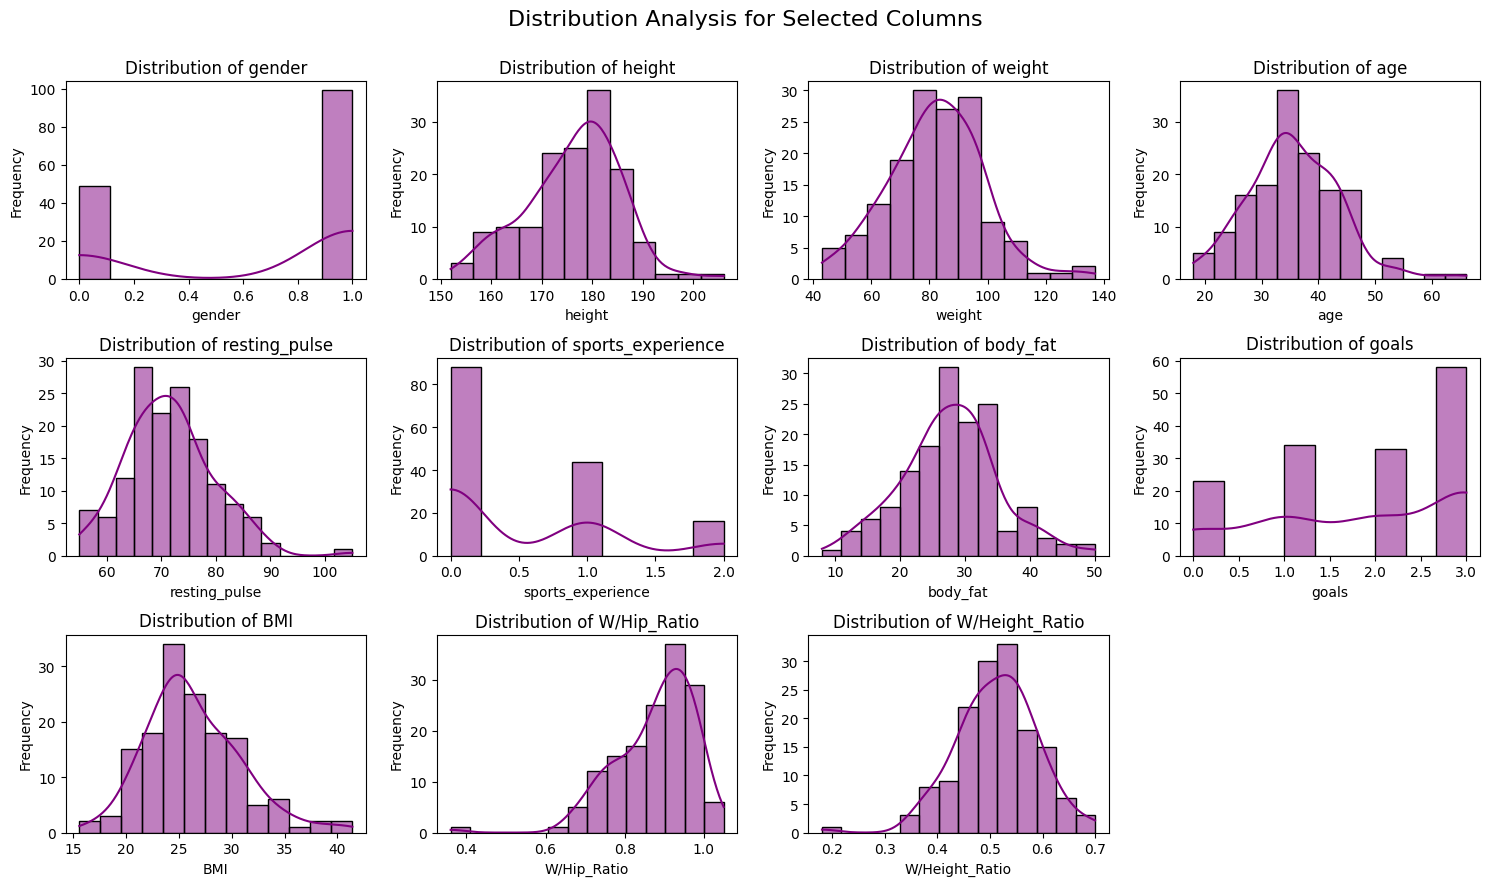

In [10]:
# Calculate the number of rows and columns for the grid of subplots
n_cols = 4  # Number of plots per row
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Number of rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() 

# Her sütun için histogram çizimi
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=VT, x=column, ax=axes[i], kde=True, color='purple')  # KDE'yi isteğe bağlı kullanabilirsiniz
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Boş subplotları kaldır (eğer varsa)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Genel başlık ve düzenlemeler
fig.suptitle('Distribution Analysis for Selected Columns', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Genel başlık için üst boşluk
plt.show()

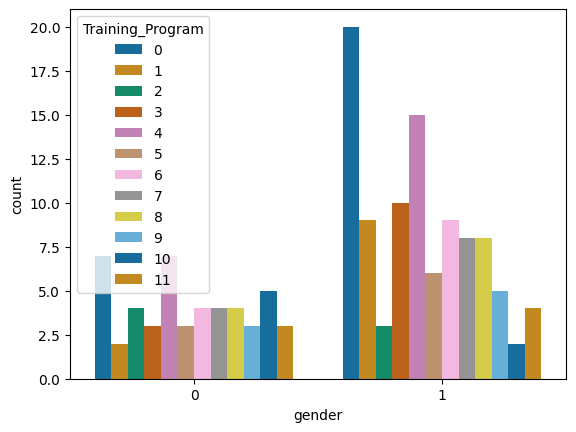

In [11]:
# Seaborn'ın renk körü dostu paleti
sns.countplot(data=VT, x='gender', hue='Training_Program', palette="colorblind")
plt.show()

<Axes: xlabel='height', ylabel='weight'>

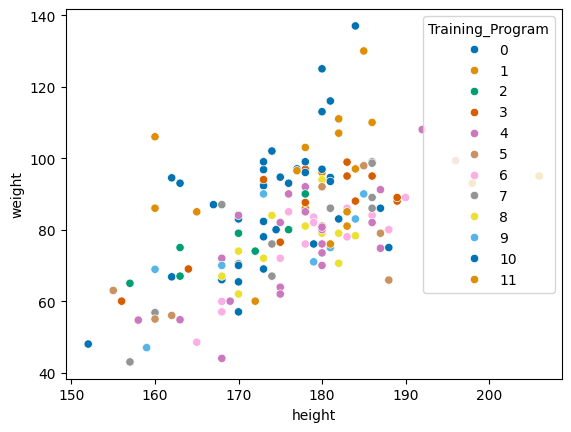

In [12]:
sns.scatterplot(data=VT, x='height', y='weight', hue='Training_Program', palette="colorblind")

<Axes: xlabel='Training_Program', ylabel='age'>

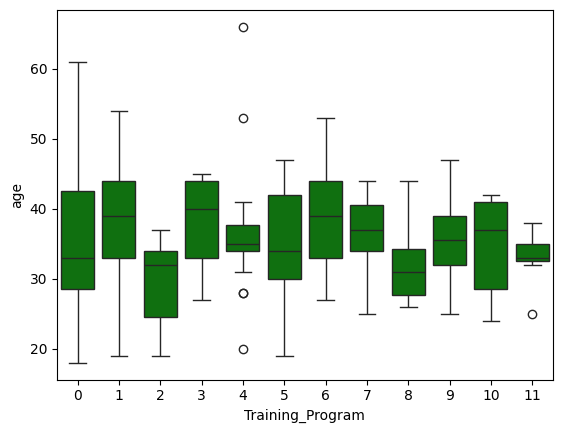

In [13]:
sns.boxplot(data=VT, x='Training_Program', y='age', color= "green")

<Axes: xlabel='sports_experience', ylabel='count'>

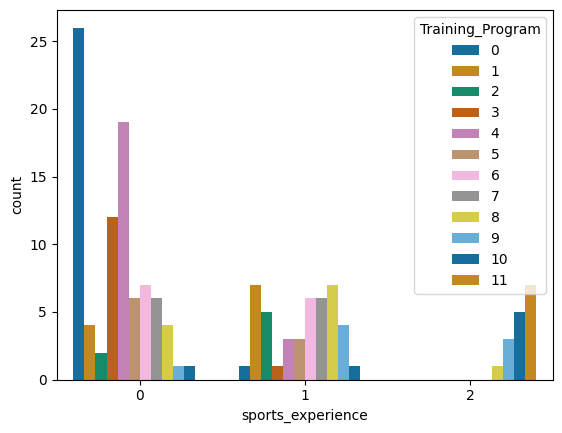

In [14]:
sns.countplot(data=VT, x='sports_experience', hue='Training_Program', palette="colorblind")

<Axes: xlabel='body_fat', ylabel='BMI'>

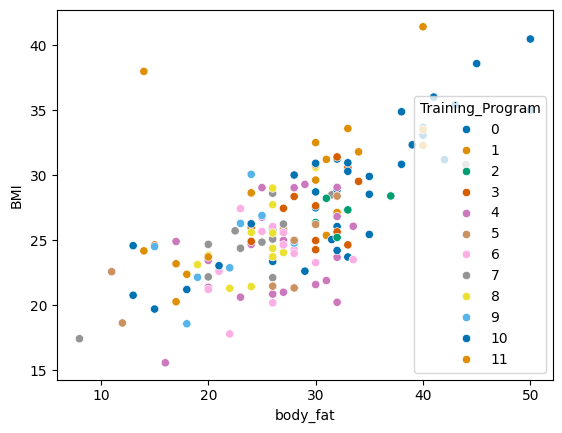

In [15]:
sns.scatterplot(data=VT, x='body_fat', y='BMI', hue='Training_Program', palette="colorblind")

<Axes: xlabel='goals', ylabel='count'>

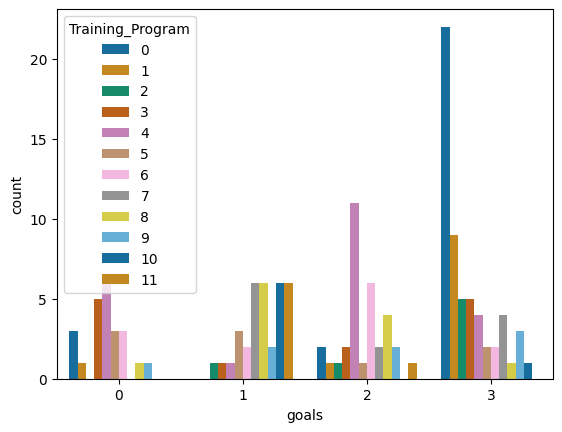

In [16]:
sns.countplot(data=VT, x='goals', hue='Training_Program', palette="colorblind")


<Axes: xlabel='Training_Program', ylabel='W/Hip_Ratio'>

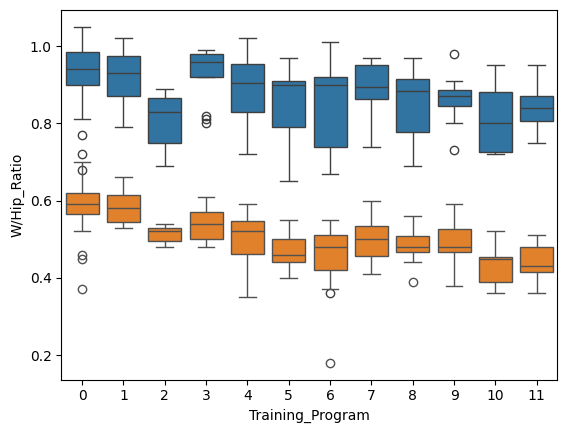

In [17]:
sns.boxplot(data=VT, x='Training_Program', y='W/Hip_Ratio')
sns.boxplot(data=VT, x='Training_Program', y='W/Height_Ratio')


Correlation Analysis

Training_Program      1.000000
sports_experience     0.601449
height                0.135502
age                  -0.056866
surgeries            -0.074374
gender               -0.139889
chronic_conditions   -0.174916
W/Hip_Ratio          -0.268595
resting_pulse        -0.298671
weight               -0.335419
goals                -0.371408
BMI                  -0.491470
W/Height_Ratio       -0.571551
body_fat             -0.693959
Name: Training_Program, dtype: float64


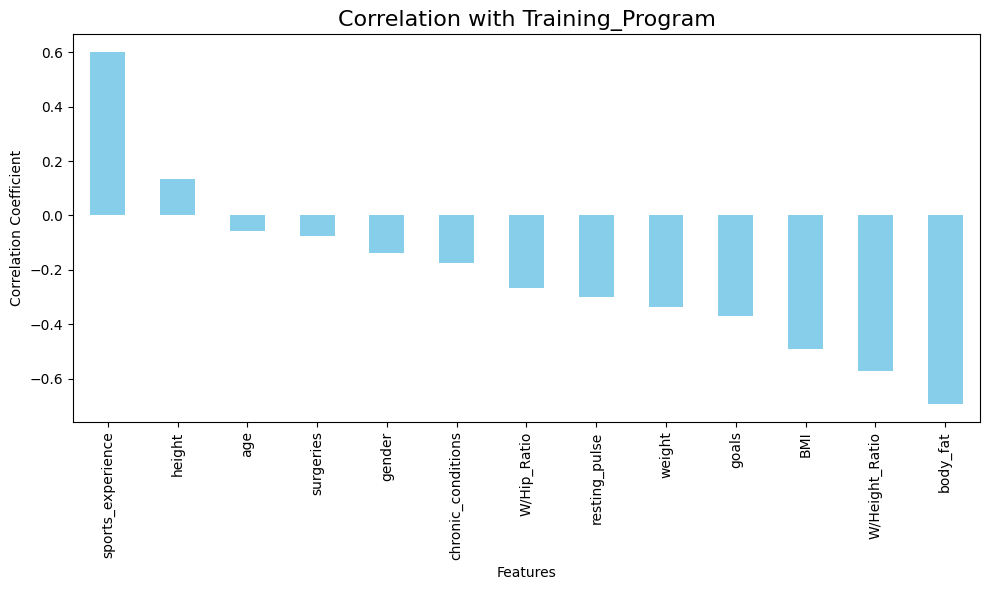

In [19]:
# Hedef değişken ile korelasyonu hesapla
target_corr = VT.corr()['Training_Program'].sort_values(ascending=False)

# Korelasyon sonuçlarını yazdır
print(target_corr)

# Görselleştirme
plt.figure(figsize=(10, 6))
target_corr.drop('Training_Program').plot(kind='bar', color='skyblue')  # Hedef değişkenin kendisini hariç tut
plt.title('Correlation with Training_Program', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('training_program_correlation.png', dpi=300)
plt.show()
